an example

In [30]:
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.metrics import brier_score_loss
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
# generate data
X, y = make_classification(n_samples=1000,
                           n_features=20,
                           n_classes=2,
                           weights=[0.99,0.1],
                           random_state=42)

In [3]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [4]:
# initialize rfc
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [5]:
# calibrate probabilities using Platt Scaling
calibrated_rfc = CalibratedClassifierCV(estimator=rfc,
                                        method='sigmoid',
                                        cv='prefit')
calibrated_rfc.fit(X_train, y_train)

/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit', estimator=RandomForestClassifier())

In [6]:
prob_true_base, prob_pred_base = calibration_curve(y_test, rfc.predict_proba(X_test)[:,1], n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, calibrated_rfc.predict_proba(X_test)[:,1], n_bins=10)


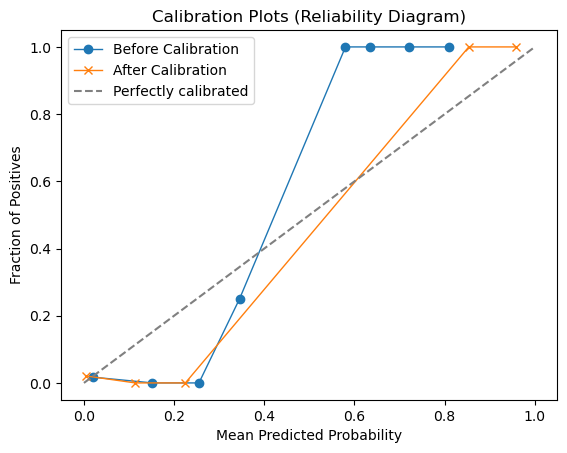

In [7]:
# Plotting
plt.plot(prob_pred_base, prob_true_base, marker='o', linewidth=1, label='Before Calibration')
plt.plot(prob_pred_cal, prob_true_cal, marker='x', linewidth=1, label='After Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (Reliability Diagram)')
plt.legend()
plt.show()

another example

In [14]:
# generate our data
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=2,
    n_redundant=10,
    n_clusters_per_class=1,
    weights=[0.994, 0.006],
    flip_y=0,
    random_state=42
)

In [17]:
np.bincount(y)

array([9940,   60])

In [ ]:
# Split: 64% train, 16% calibration, 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_calib, y_train, y_calib = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)


In [19]:
clf = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')

In [ ]:
probs_uncal = clf.predict_proba(X_test)[:, 1]

In [20]:
# Calibrate on a separate validation set (cv='prefit' because clf is already fit)
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv='prefit')
calibrated_clf.fit(X_calib, y_calib)


/Users/rebekaheichberg/anaconda3/envs/erdos_summer_2025/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


CalibratedClassifierCV(cv='prefit',
                       estimator=LogisticRegression(class_weight='balanced',
                                                    max_iter=1000,
                                                    solver='liblinear'))

In [27]:
probs_cal = calibrated_clf.predict_proba(X_test)[:, 1]


In [28]:
fop_uncal, mpv_uncal = calibration_curve(y_test, probs_uncal, n_bins=10)
fop_cal, mpv_cal = calibration_curve(y_test, probs_cal, n_bins=10)

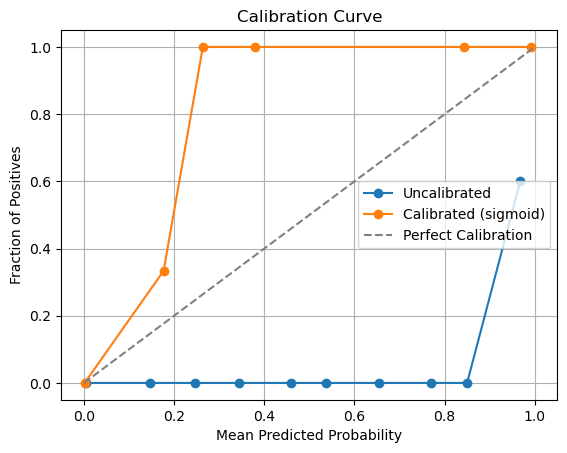

In [29]:
plt.plot(mpv_uncal, fop_uncal, marker='o', label='Uncalibrated')
plt.plot(mpv_cal, fop_cal, marker='o', label='Calibrated (sigmoid)')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()


In [31]:
brier_uncal = brier_score_loss(y_test, probs_uncal)
brier_cal = brier_score_loss(y_test, probs_cal)

print(f"Brier score (uncalibrated): {brier_uncal:.6f}")
print(f"Brier score (calibrated)  : {brier_cal:.6f}")

Brier score (uncalibrated): 0.011807
Brier score (calibrated)  : 0.001986


In [24]:
import pandas as pd
df = pd.DataFrame({'prob_class_1': probs, 'true_label': y_test})
df_sorted = df.sort_values(by='prob_class_1', ascending=False)

print("Top 20 predictions with highest class 1 probabilities:")
print(df_sorted.head(20))


Top 20 predictions with highest class 1 probabilities:
      prob_class_1  true_label
702       0.999971           1
231       0.999401           1
1534      0.990351           1
366       0.987542           1
468       0.980433           1
676       0.841995           1
1715      0.378758           1
1294      0.268484           1
1547      0.258911           1
394       0.197694           0
363       0.184699           1
1703      0.147587           0
1721      0.098231           1
1055      0.095178           0
1642      0.085128           0
1565      0.084810           1
1492      0.084006           0
527       0.072626           0
1284      0.071783           0
50        0.071115           0


In [32]:
avg_prob = np.mean(probs_cal)
print(f"Average predicted probability: {avg_prob:.6f}")

Average predicted probability: 0.005585


In [33]:
# Get predictions above average where the true label is 1
df = pd.DataFrame({'prob': probs_cal, 'true_label': y_test})
positive_preds = df[df['true_label'] == 1]

# How many class 1 predictions are above the average probability?
high_confidence_positives = positive_preds[positive_preds['prob'] > avg_prob]

print(f"Total class 1 samples in test set: {len(positive_preds)}")
print(f"Class 1 predictions with prob > avg: {len(high_confidence_positives)}")


Total class 1 samples in test set: 12
Class 1 predictions with prob > avg: 12
